# Particle Swarm Optimization (PSO)

A softpy‑compatible implementation of Particle Swarm Optimization (PSO) for continuous optimisation tasks, developed for the **Fuzzy Systems & Evolutionary Computing** project (a.y. 2024/2025).

Mucaj Deva - 535333

---
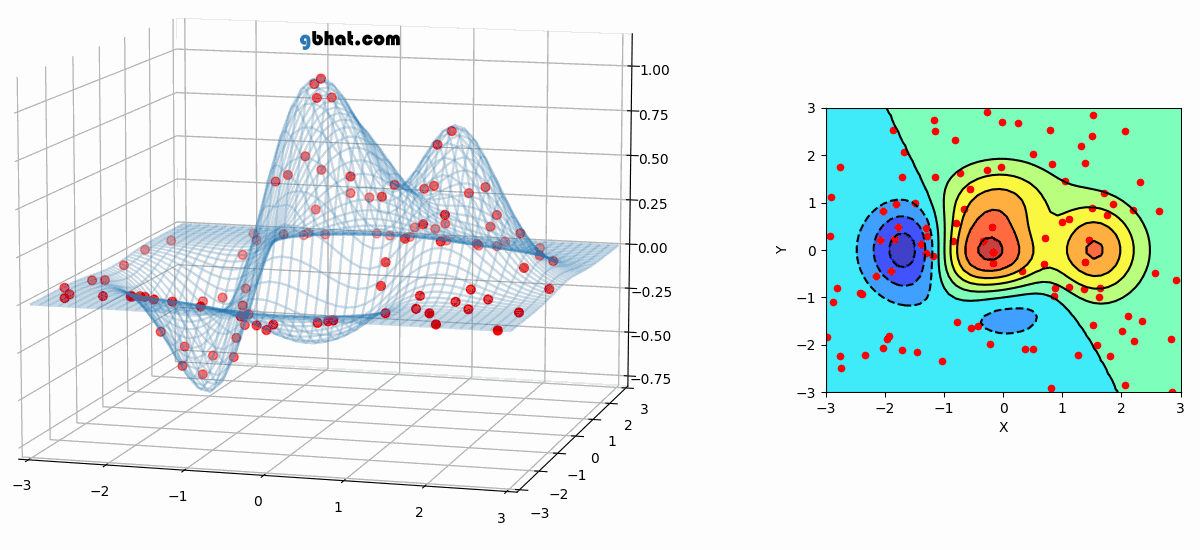

This repository provides a small, PSO implementation designed for **clarity**, **explainability**, and **safe defaults**. It includes:

* A `ParticleCandidate` that is compatible with `softpy.FloatVectorCandidate` while preserving strict internal invariants (no accidental aliasing of bounds).
* A `ParticleSwarmOptimizer` with a sensible inertia schedule, tapered velocity capping, reflective boundary handling, and optional annealed Gaussian noise.
* A self-contained Rosenbrock demo with logging and a convergence plot.

> **Optimization mode:** This PSO is written in **maximization** form. To **minimize** a function `f`, pass `fitness = -f`.

---

## Table of Contents

1. [Project Structure](#project-structure)
2. [Key Ideas & Design Choices](#key-ideas--design-choices)
3. [Installation](#installation)
4. [Quickstart (Rosenbrock Demo)](#quickstart-rosenbrock-demo)
5. [API Overview](#api-overview)

   * [ParticleCandidate](#particlecandidate)
   * [ParticleSwarmOptimizer](#particleswarmoptimizer)
6. [Defining Your Fitness Function](#defining-your-fitness-function)

   * [Scalar fitness](#scalar-fitness)
   * [Vectorized fitness](#vectorized-fitness)
7. [Parameter Guide](#parameter-guide)
8. [Tips for Stability and Performance](#tips-for-stability-and-performance)
9. [Troubleshooting and Notes](#troubleshooting-and-notes)

---

## Project Structure

```
├─ pso_candidate.py        # Particle definition + safe bounds and reflection
├─ swarm_optimizer.py      # PSO loop, scheduling, logging, history
└─ rosenbrock_demo.py      # Demo: optimize the (negative) Rosenbrock function
```

* **`pso_candidate.py`**
  Implements `ParticleCandidate`, a PSO particle that:

  * Enforces correct shapes and dtypes.
  * Keeps **private, frozen** copies of bounds (`_lower/_upper`) to avoid external mutation.
  * Performs **multi-bounce reflective** updates with optional Gaussian noise.

* **`swarm_optimizer.py`**
  Implements `ParticleSwarmOptimizer`, which:

  * Supports both **scalar** and **vectorized** fitness functions.
  * Uses a **quadratic** inertia schedule (`w_max → w_min`).
  * Caps velocity by a fraction of the box **and** tapers that cap over time.
  * Tracks **best**, **mean**, and **std** fitness per iteration for analysis.

* **`rosenbrock_demo.py`**
  Runs a reproducible demo on the Rosenbrock function (minimization via negative sign), logs progress, and plots convergence.

---

## Key Ideas & Design Choices

* **Safety and Interpretability**

  * All array shapes are validated. Bounds are checked for **strictly positive span** per dimension.
  * Detached, frozen bounds to prevent aliasing bugs (memory location is accessed through more than one reference in an unexpected way).

* **Robust Boundary Handling**

  * Reflection uses **modulo arithmetic** on a doubled span: handles **arbitrary** number of bounces in **closed form** (no while loops).

* **Convergence friendly Defaults**

  * Inertia decays from `w_max` to `w_min` **quadratically**.
  * Velocity cap scales with box size via `vmax_ratio` and **shrinks** as the iterations progress.

* **Diagnostics**

  * We use history arrays (`history_best`, `history_mean`, `history_std`) that enable plots and sanity checks.
  * Logging prints a compact per iteration summary.

---

## Installation

This project requires Python **3.8+**.

**Dependencies:**

**Runtime (required)**

* `numpy>=1.24,<2.0`
* `softpy>=0.1.2`

**Demo (optional)**

* `matplotlib>=3.5` - only needed for the Rosenbrock plot

### Quick install (direct)

```bash
# Library only
pip install "numpy>=1.24,<2.0" "softpy>=0.1.2"

# if you also want to run the demo plot
pip install "matplotlib>=3.5"
```

### Install from requirement file

```bash
# Library only
pip install -r requirements.txt

# Demo plotting Support
pip install -r demo_requirements.txt
```

---

## Quickstart (with the rosenbrock demo)

Run the demo:

```bash
python rosenbrock_demo.py
```

What you’ll see:

* Console logs like `Iter  42/150 | Best: ... | Mean: ...`.
* A plot of the **objective** (best and mean ± std) on a log scale.
* Printed consistency check verifying that the best object’s value matches the tracked best.

You will see something like this:

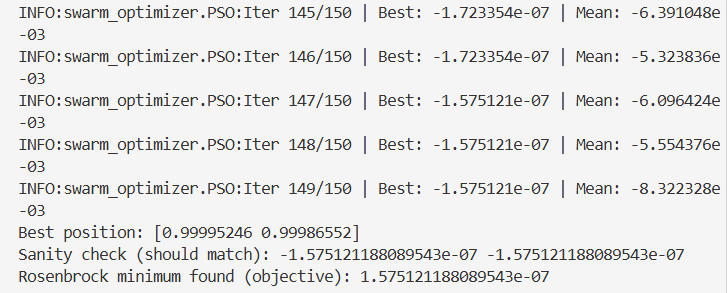
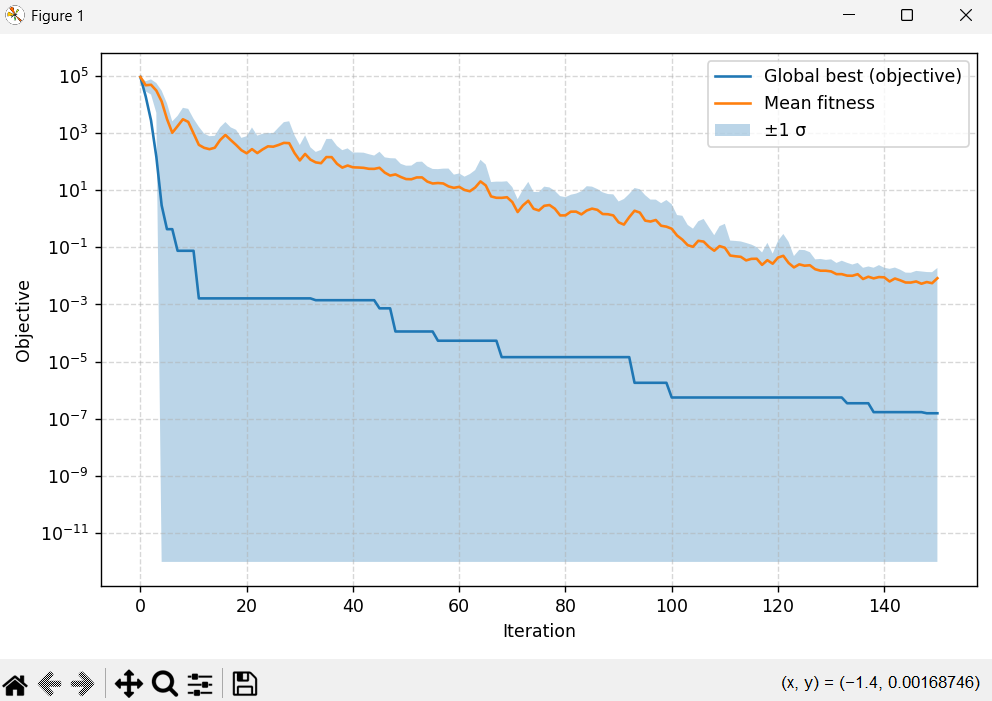

---

## API Overview

### `ParticleCandidate`

```python
from pso_candidate import ParticleCandidate
```

**Purpose:** encapsulates a PSO particle’s **position** and **velocity**, with safe, frozen bounds for all internal operations.

**Key behavior:**

As already said,

* `position` always lives **inside** the box.
* `mutate(noise_sigma)` performs a reflective step plus optional Gaussian noise.
* `_clip_velocity(vmax)` caps velocities (scalar or per-dimension array).

**Factory:**

```python
ParticleCandidate.generate(
    size=dim, lower=lb, upper=ub,
    inertia=..., wl=..., wn=..., wg=...,
    vmax_ratio=..., rng=...
)
```

### `ParticleSwarmOptimizer`

```python
from swarm_optimizer import ParticleSwarmOptimizer
```

**Purpose:** Run PSO over a population with:

* inertia schedule,
* tapered velocity capping,
* optional annealed Gaussian noise,
* neighborhood bests (random fixed degree neighborhoods).

**Core methods adn properties:**

* `fit(n_iters: int) -> ParticleCandidate`
  Runs the loop and returns the **best particle** (synced with `gbest_pos`).
* `history_best`, `history_mean`, `history_std`
  Numpy arrays for plotting and analysis.
* `global_fitness_best`, `gbest_pos`, `global_best`
  Best-known fitness/value/particle at termination.

---

## Defining Your Fitness Function

This PSO **maximizes** whatever you return. To **minimize** `f(x)`, return `-f(x)`. You can both use a scalar fitness, or a vectorized fitness, here are a couple examples:

### Scalar fitness

Signature: `Callable[[ParticleCandidate], float]`

```python
def neg_sphere(p: ParticleCandidate) -> float:
    x = p.position
    return -float(np.dot(x, x))  # minimize ||x||^2

pso = ParticleSwarmOptimizer(
    fitness_func=neg_sphere,
    pop_size=50, n_neighbors=5,
    size=dim, lower=lb, upper=ub,
)
best = pso.fit(n_iters=200)
```

### Vectorized fitness

Signature: `Callable[[NDArray[np.floating]], NDArray[np.floating]]` where input is `(pop_size, dim)` and output is `(pop_size,)`.

Mark your function as vectorized by either:

* Passing `vectorized=True` to the optimizer, **or**
* Setting `your_func._vectorized = True`.

```python
def neg_sphere_vec(X: np.ndarray) -> np.ndarray:
    # X shape: (pop, dim)
    return -np.sum(X * X, axis=1)

neg_sphere_vec._vectorized = True

pso = ParticleSwarmOptimizer(
    fitness_func=neg_sphere_vec,
    pop_size=200, n_neighbors=10,
    size=dim, lower=lb, upper=ub,
    vectorized=True,
)
best = pso.fit(n_iters=150)
```

---

## Parameter Guide

* **`size`**: problem dimension (must be ≥ 1).
* **`lower`, `upper`**: per-dimension bounds, shape `(size,)`, with `upper > lower` element-wise.
* **`wl`, `wn`, `wg`**: cognitive / neighborhood / global weights, **sum to 1**, each must be in `[0,1]`.
* **`w_max`, `w_min`**: inertia starts at `w_max` and decays (quadratically by default) to `w_min`.
* **`w_schedule(frac)`**: optional custom schedule (`frac` goes from 0 to 1 across iterations).
* **`vmax_ratio`**: per-dimension velocity cap as a fraction of the box span (also multiplied by `(1 - progress)` each iteration).
* **`noise_sigma`**: std-dev of Gaussian noise added **after** reflection (annealed).
* **`noise_decay`**: multiplicative decay per iteration in `[0,1]`.
* **`sigma_cutoff`**: noise is considered effectively zero once below this threshold (defaults to `max(noise_sigma * 1e-3, TINY)`).
* **`n_neighbors`**: number of neighbors used to form a local best; neighbors are sampled once at the start (without replacement).
* **`rng`**: `np.random.Generator` for reproducibility.
* **`verbose`**: toggles INFO logging.

---

## Tips for Stability and Performance

* **Scale the box sensibly**
  Overly large boxes can cause long reflective “bounces” and slow convergence.

* **Noise annealing**
  A small `noise_sigma` with `noise_decay∈(0,1)` can help escape local traps early and fade out later.

---

## Troubleshooting and Notes

* **Bounds shape error**
  Ensure `lower.shape == upper.shape == (size,)`.

* **Weights must sum to 1**
  If `wl + wn + wg != 1`, the constructor will raise.

* **Vectorized output length**
  In vectorized mode, return a 1D array of length exactly `pop_size`.

* **Logging level**
  The demo sets `logging.basicConfig(level=logging.INFO)`. Reduce verbosity by passing `verbose=False` to the optimizer.

* **Reproducibility**
  Pass a seeded generator, e.g., `rng=np.random.default_rng(42)`.

* **Note on noise cutoff logic**
  The implementation computes a `t_star` when `noise_decay∈(0,1)`. If you set `noise_sigma==0`, or `noise_decay` in `{0,1}`, the code’s final assignment of `_noise_stop_iter` references `t_star` even though it’s defined only in the `else` branch.
  *Practical workaround:* Keep `noise_decay` strictly in `(0,1)` when `noise_sigma>0`, or set `noise_sigma=0` and ignore noise entirely.